# Keras Price Predictor - Paperspace

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm.notebook import trange, tqdm

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import wandb
from wandb.keras import WandbCallback
wandb.login()

from helpers import load_close_data, get_n_test_samples, \
                    repeat_evaluate, summarize_scores, train_and_validate

DOWNLOAD_DIR = Path('../download')
DATA_DIR = Path('../data')

sns.set()

wandb: Currently logged in as: theadammurphy (use `wandb login --relogin` to force relogin)


In [2]:
data = load_close_data(DOWNLOAD_DIR, dropna=True)
data.shape

(92192,)

# Manual LR Scheduling


RUN NUMBER 0



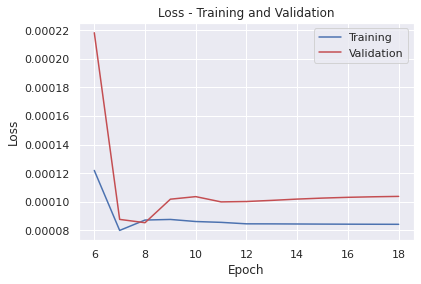

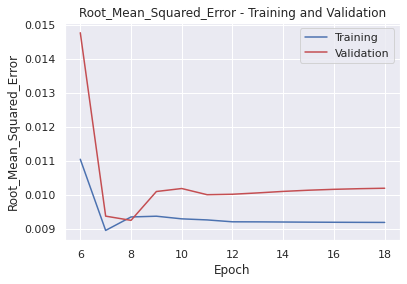

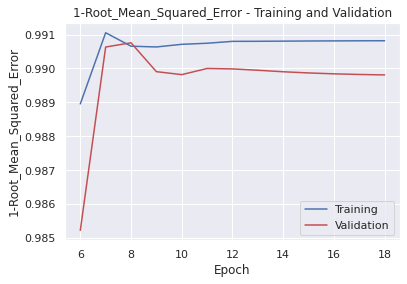

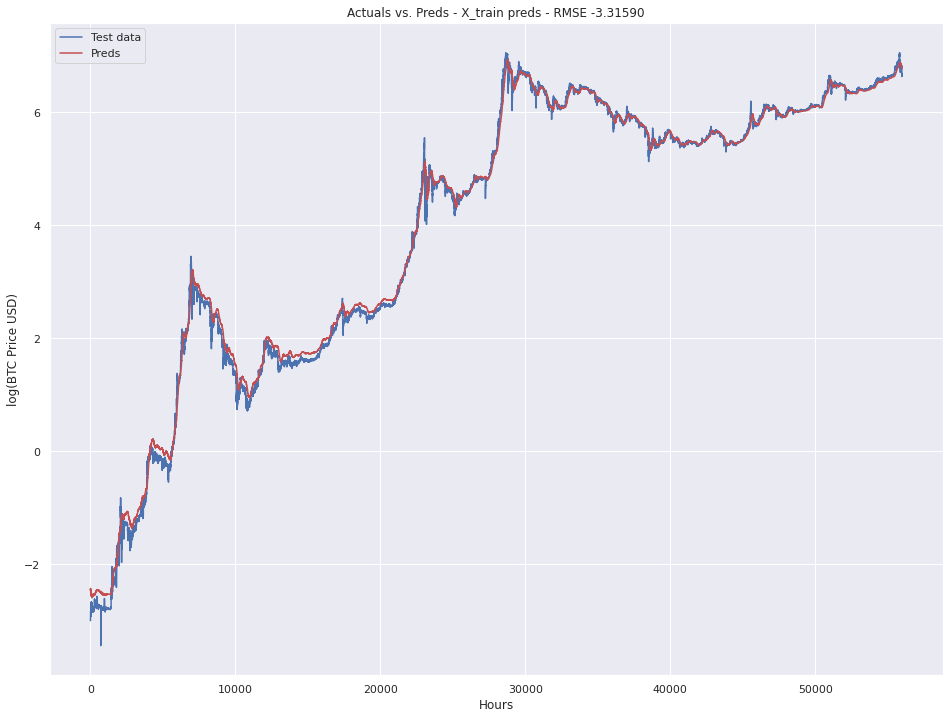

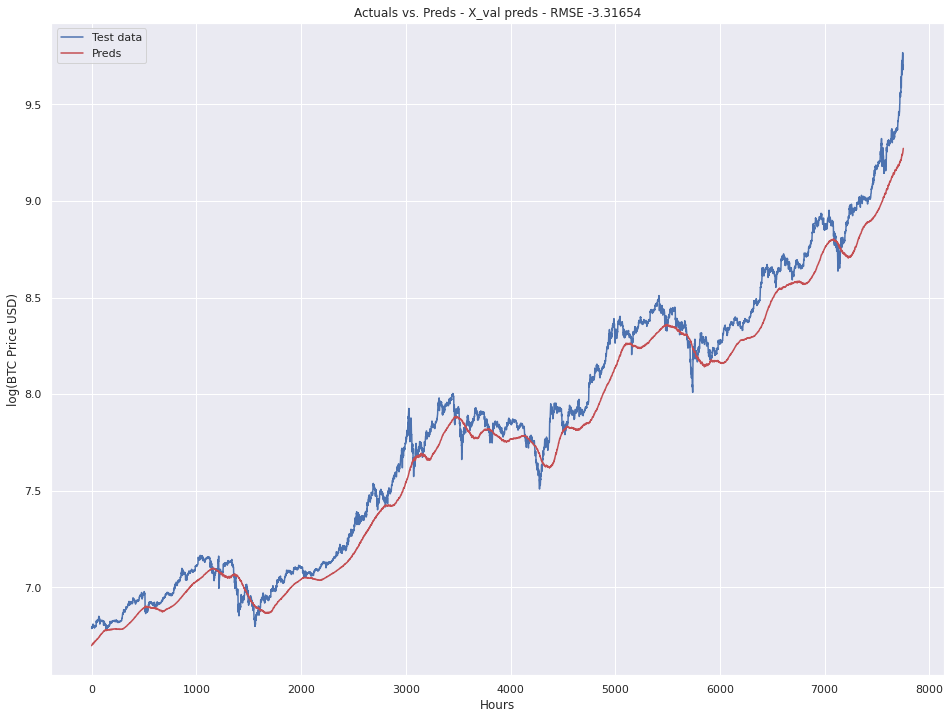

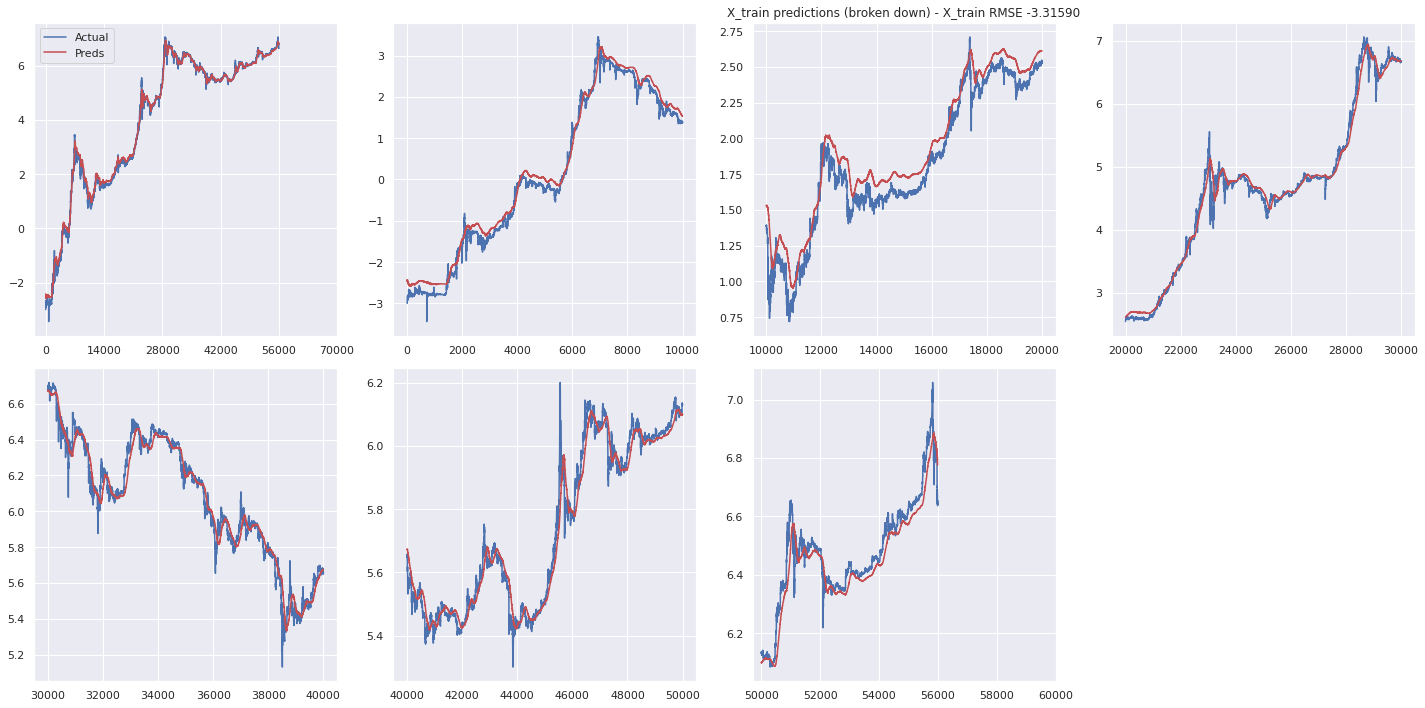

epoch,17
loss,8e-05
root_mean_squared_error,0.00918
val_loss,0.0001
val_root_mean_squared_error,0.01019
_runtime,17
_timestamp,1618469726
_step,24
best_val_loss,9e-05
best_epoch,7


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


In [6]:
for i in range(1):
    print(f'\nRUN NUMBER {i}\n')
    run = wandb.init(project='bitcoin_price_predictor',
                    config={
                        'dataset': 1,
                        # log, log_and_divide_a, log_and_range_a_b
                        'scaler': 'log_and_range_0_1',
                        'n_input': 168, # num lag observations
                        #'n_nodes': 300, # num nodes per lauyer
                        'n_epochs': 150, # num training epochs
                        'n_batch': 168 * 20, # batch size
                        #'num_layers': 3, # num layers used in MLP
                        'model_type': 'MLP',
                        'activation': 'relu',
                        'loss': 'mse',
                        # Model LR scheduler and optimizer
                        'use_lr_scheduler': False,
#                         'lr_scheduler': 'custom',
#                         'initial_lr': 1e-4,
                        'optimizer': 'adam',
                        'patience': 10,
                        'restore_best_weights': True,
                        'early_stopping_baseline': None, # set to None if there isn't one
                        # Other
                        'verbose': 0, # control verbosity of Keras fit
                        'dropna': True, # whether to drop missing values from data
                        'start_plotting_epoch': 5
                            })
    config = wandb.config # we use this to configure our experiment

    history = train_and_validate(config)
run.finish()

# LSTM


RUN NUMBER 0



epoch,1
loss,0.03527
root_mean_squared_error,0.1878
val_loss,0.0564
val_root_mean_squared_error,0.23748
_runtime,18
_timestamp,1618580032
_step,1
best_val_loss,0.0564
best_epoch,1


epoch,▁█
loss,█▁
root_mean_squared_error,█▁
val_loss,█▁
val_root_mean_squared_error,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


Epoch 1/150
37/37 [==============================] - 46s 979ms/step - loss: 0.1519 - root_mean_squared_error: 0.3734 - val_loss: 0.3385 - val_root_mean_squared_error: 0.5818
Epoch 2/150
37/37 [==============================] - 34s 912ms/step - loss: 0.0509 - root_mean_squared_error: 0.2150 - val_loss: 0.0976 - val_root_mean_squared_error: 0.3125
Epoch 3/150
37/37 [==============================] - 34s 919ms/step - loss: 0.0041 - root_mean_squared_error: 0.0599 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 4/150
37/37 [==============================] - 34s 916ms/step - loss: 0.0095 - root_mean_squared_error: 0.0964 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 5/150
37/37 [==============================] - 34s 920ms/step - loss: 0.0083 - root_mean_squared_error: 0.0905 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 6/150
37/37 [==============================] - 34s 922ms/step - loss: 0.0068 - root_mean_squared_error: 0.0818 - val_loss: 0

37/37 [==============================] - 34s 933ms/step - loss: 1.4586e-04 - root_mean_squared_error: 0.0120 - val_loss: 8.8997e-04 - val_root_mean_squared_error: 0.0298
Epoch 46/150
37/37 [==============================] - 35s 934ms/step - loss: 1.4358e-04 - root_mean_squared_error: 0.0119 - val_loss: 8.8842e-04 - val_root_mean_squared_error: 0.0298
Epoch 47/150
37/37 [==============================] - 35s 934ms/step - loss: 1.4143e-04 - root_mean_squared_error: 0.0118 - val_loss: 8.8748e-04 - val_root_mean_squared_error: 0.0298
Epoch 48/150
37/37 [==============================] - 35s 936ms/step - loss: 1.3945e-04 - root_mean_squared_error: 0.0118 - val_loss: 8.8696e-04 - val_root_mean_squared_error: 0.0298
Epoch 49/150
37/37 [==============================] - 34s 933ms/step - loss: 1.3765e-04 - root_mean_squared_error: 0.0117 - val_loss: 8.8676e-04 - val_root_mean_squared_error: 0.0298
Epoch 50/150
37/37 [==============================] - 35s 934ms/step - loss: 1.3604e-04 - root_mea

Epoch 90/150
37/37 [==============================] - 34s 929ms/step - loss: 1.6559e-04 - root_mean_squared_error: 0.0128 - val_loss: 7.3007e-04 - val_root_mean_squared_error: 0.0270
Epoch 91/150
37/37 [==============================] - 34s 933ms/step - loss: 1.6680e-04 - root_mean_squared_error: 0.0129 - val_loss: 7.2150e-04 - val_root_mean_squared_error: 0.0269
Epoch 92/150
37/37 [==============================] - 34s 930ms/step - loss: 1.6792e-04 - root_mean_squared_error: 0.0129 - val_loss: 7.1287e-04 - val_root_mean_squared_error: 0.0267
Epoch 93/150
37/37 [==============================] - 35s 935ms/step - loss: 1.6894e-04 - root_mean_squared_error: 0.0129 - val_loss: 7.0421e-04 - val_root_mean_squared_error: 0.0265
Epoch 94/150
37/37 [==============================] - 35s 935ms/step - loss: 1.6987e-04 - root_mean_squared_error: 0.0130 - val_loss: 6.9553e-04 - val_root_mean_squared_error: 0.0264
Epoch 95/150
37/37 [==============================] - 35s 935ms/step - loss: 1.7070e-

37/37 [==============================] - 35s 936ms/step - loss: 1.6379e-04 - root_mean_squared_error: 0.0127 - val_loss: 4.0227e-04 - val_root_mean_squared_error: 0.0201
Epoch 135/150
37/37 [==============================] - 35s 936ms/step - loss: 1.6319e-04 - root_mean_squared_error: 0.0127 - val_loss: 3.9621e-04 - val_root_mean_squared_error: 0.0199
Epoch 136/150
37/37 [==============================] - 35s 934ms/step - loss: 1.6258e-04 - root_mean_squared_error: 0.0127 - val_loss: 3.9018e-04 - val_root_mean_squared_error: 0.0198
Epoch 137/150
37/37 [==============================] - 35s 944ms/step - loss: 1.6195e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.8419e-04 - val_root_mean_squared_error: 0.0196
Epoch 138/150
37/37 [==============================] - 34s 932ms/step - loss: 1.6132e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.7825e-04 - val_root_mean_squared_error: 0.0194
Epoch 139/150
37/37 [==============================] - 35s 935ms/step - loss: 1.6068e-04 - roo

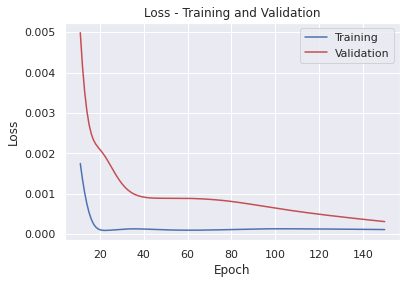

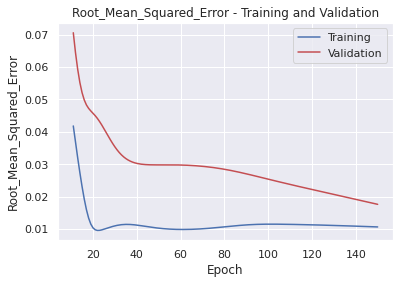

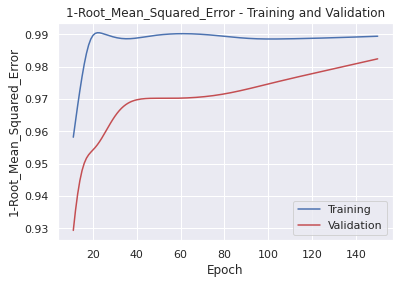

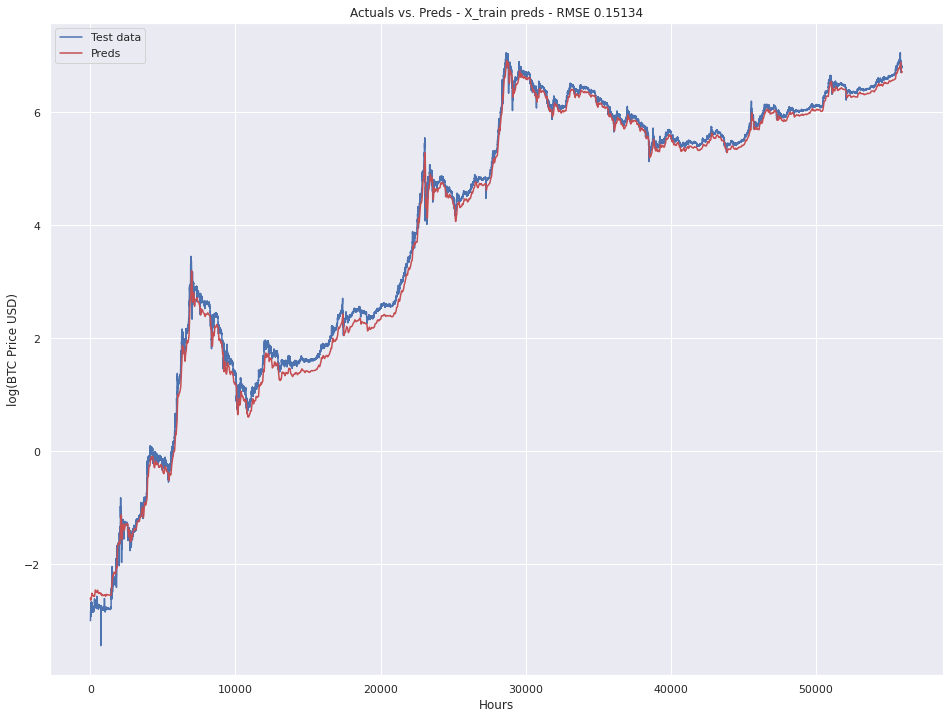

37/37 [==============================] - 35s 938ms/step - loss: 0.0095 - root_mean_squared_error: 0.0924 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2738
Epoch 5/150
35/37 [===========================>..] - ETA: 1s - loss: 0.0149 - root_mean_squared_error: 0.1218

KeyboardInterrupt: 

In [4]:
for i in range(5):
    print(f'\nRUN NUMBER {i}\n')
    run = wandb.init(project='bitcoin_price_predictor',
                    config={
                        ### Data preparation
                        'dataset': 1,
                        'scaler': 'log_and_range_0_1', #  log, log_and_divide_a, log_and_range_a_b
                        'n_input': 168, # num lag observations
                        ### Model build
                        'model_type': 'LSTM',
                        'activation': 'relu',
                        'loss': 'mse',
                        'optimizer': 'adam', # adam, rmsprop
                        #### LR scheduler and optimizer
                        'use_lr_scheduler': False,
#                         'lr_scheduler': 'custom', # InverseTimeDecay, ExponentialDecay, cusom
#                         'initial_lr': 1e-4,
                        'lr': 1e-5, # if use_lr_scheduler == False for fixed LR
                        ### Model fit
                        'n_epochs': 150, # num training epochs
                        'n_batch': 168 * 9, # batch size
                        'verbose': 1, # verbosity of  fit
                        ### EarlyStopping callback
                        'patience': 10,
                        'restore_best_weights': True,
                        'early_stopping_baseline': None, # set to None if there isn't one
                        # Plots
                        'start_plotting_epoch': 10
                            })
    config = wandb.config # we use this to configure our experiment

    history = train_and_validate(config)
run.finish()

If ravel=False in X_train_log and X_val_log we get 
```python
ValueError: Data cardinality is ambiguous:
  x sizes: 37
  y sizes: 55944
```

If ravel=True in X_train_log and X_val_log we get
```python
ValueError: Data cardinality is ambiguous:
  x sizes: 9398592
  y sizes: 55944
```

In [21]:
from helpers import load_dataset_1, scale_train_val, transform_to_keras_input, build_model, fit_model, \
                    convert_to_log, transform_to_keras_input

run = wandb.init(project='bitcoin_price_predictor',
                config={
                    'dataset': 1,
                    # log, log_and_divide_a, log_and_range_a_b
                    'scaler': 'log_and_range_0_1',
                    'n_input': 168, # num lag observations
                    #'n_nodes': 300, # num nodes per lauyer
                    'n_epochs': 2, # num training epochs
                    'n_batch': 168 * 9, # batch size
                    #'num_layers': 3, # num layers used in MLP
                    'model_type': 'LSTM',
                    'activation': 'relu',
                    'loss': 'mse',
                    ### Model LR scheduler and optimizer
                    'use_lr_scheduler': False,
#                         'lr_scheduler': 'custom',
#                         'initial_lr': 1e-4,
                    'lr': 1e-4, # if use_lr_scheduler == False
                    'optimizer': 'adam',
                    ### EarlyStopping callback ###
                    'patience': 10,
                    'restore_best_weights': True,
                    'early_stopping_baseline': None, # set to None if there isn't one
                    # Other
                    'verbose': 1, # control verbosity of Keras fit
                    'dropna': True, # whether to drop missing values from data
                    'start_plotting_epoch': 0
                        })
config = wandb.config

# Load data
train, val, _ = load_dataset_1()
# Scale data
train_scaled, val_scaled = scale_train_val(train, val, scaler=config.scaler)
# Get data into form Keras needs
# NAME OF THIS FUNCTION IS MISLEADING AS THE OUTPUT IS NOT IN A FORM
# KERAS LIKES IF IT'S AN LSTM (IT'S BETTER TO TRANSFORM IT INTO
# A TF.DATA.DATASET CLASS).
X_train, X_val, y_train, y_val = transform_to_keras_input(config,
                                                          train_scaled,
                                                          val_scaled,
                                                          config.n_input)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
# Build and fit model
model = build_model(config)
history = fit_model(model, config, X_train, X_val, y_train, y_val)

"""ALL NEW FROM HERE"""
if config.model_type.upper() == 'LSTM':
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.batch(config.n_batch, drop_remainder=True)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) 
    val_ds = val_ds.batch(config.n_batch, drop_remainder=True)

    y_pred_train = model.predict(train_ds)
    y_pred_val = model.predict(val_ds)    

train_log, val_log = scale_train_val(train, val, scaler='log')

y_pred_train_log, y_pred_val_log = convert_to_log([y_pred_train, y_pred_val],
                                                   config.scaler,
                                                   train_log,
                                                   val_log)

X_train_log, X_val_log, y_train_log, y_val_log = transform_to_keras_input(
                                                    config,
                                                    train_log,
                                                    val_log,
                                                    config.n_input
                                                    )

print('After transform_to_keras_input y_train log is')
print(type(y_train_log), y_train_log.shape)

epoch,1
loss,0.06074
root_mean_squared_error,0.24645
val_loss,0.10967
val_root_mean_squared_error,0.33117
_runtime,20
_timestamp,1618557492
_step,5
best_val_loss,0.10967
best_epoch,1


epoch,▁█
loss,█▁
root_mean_squared_error,█▁
val_loss,█▁
val_root_mean_squared_error,█▁
_runtime,▁▆▆███
_timestamp,▁▆▆███
_step,▁▂▄▅▇█


(55993, 168, 1) (7752, 168, 1) (55993,) (7752,)
Epoch 1/2
37/37 [==============================] - 10s 150ms/step - loss: 0.1018 - root_mean_squared_error: 0.3077 - val_loss: 0.1854 - val_root_mean_squared_error: 0.4306
Epoch 2/2
37/37 [==============================] - 3s 90ms/step - loss: 0.0144 - root_mean_squared_error: 0.1149 - val_loss: 0.0495 - val_root_mean_squared_error: 0.2224
After transform_to_keras_input y_train log is
<class 'numpy.ndarray'> (55993,)


In [55]:
X_train_log.shape

(55993, 168, 1)

In [60]:
# Number in X_train_log if ravel=True
9398592

9398592

In [61]:
(55993 * 168) - 9398592

8232

In [58]:
37 * 168 * 9

55944

In [62]:
55993 - 55944

49

In [63]:
f = np.arange(9398592)

In [64]:
f.reshape(-1, 168, 1).shape

(55944, 168, 1)

In [66]:
55944 / (168 * 9)

37.0

In [42]:
# I feel like there MUST be a better way to do this. 
a = tf.data.Dataset.from_tensor_slices(y_train_log)
a_batch = a.batch(config.n_batch, drop_remainder=True)
a_list = list(a_batch.as_numpy_iterator())
a_numpy = np.array(a_list)
a_flat = a_numpy.ravel()

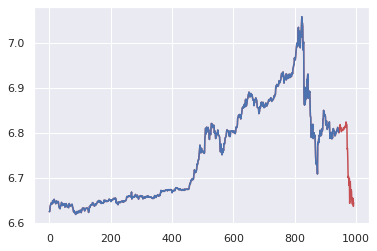

In [50]:
plt.plot(y_train_log[55000:], 'r')
plt.plot(a_flat[55000:], 'b')
plt.xlim()
plt.show()

In [34]:
len(a.batch(c).as_numpy_iterator())

TypeError: object of type '_NumpyIterator' has no len()

In [36]:
for i, elt in a.batch(config.n_batch, drop_remainder=True).enumerate():
    print(i)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(15, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(17, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)
tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(20, shape=(), dtype=int64)
tf.Tensor(21, shape=(), dtype=int64)
tf.Tensor(22, shape=(), dtype=int64)
tf.Tensor(23, shape=(), dtype=int64)
tf.Tensor(24, shape=(), dtype=int64)
tf.Tensor(25, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(2

In [ ]:
if config.model_type.upper() == 'LSTM':
    # y_pred_train_log has fewer elements that X_train_log now because
    # some were cut off at the end due to needing equally sized batches
    X_train_log = tf.data.Dataset.from_tensor_slices(X_train_log)
    X_train_log = X_train_log.batch(config.n_batch, drop_remainder=True)
    X_train_log = list(X_train_log.as_numpy_iterator())
    X_val_log = tf.data.Dataset.from_tensor_slices(X_val_log)
    X_val_log = X_val_log.batch(config.n_batch, drop_remainder=True)
    X_val_log = list(X_val_log.as_numpy_iterator())

    y_train_log = tf.data.Dataset.from_tensor_slices(y_train_log)
    y_train_log = y_train_log.batch(config.n_batch, drop_remainder=True)
    y_train_log = list(y_train_log.as_numpy_iterator())
    y_val_log = tf.data.Dataset.from_tensor_slices(y_val_log)
    y_val_log = y_val_log.batch(config.n_batch, drop_remainder=True)
    y_val_log = list(y_val_log.as_numpy_iterator())


# Test this with evaluate as well to ensure same results
print(type(y_train_log), type(y_pred_train_log))
print(f'len(y_train_log) is {len(y_train_log)}')
print(f'Shape of y_pred_train_log is {y_pred_train_log.shape}')
rmse_train_log = _measure_rmse(y_train_log, y_pred_train_log)
rmse_val_log = _measure_rmse(y_val_log, y_pred_val_log)

In [3]:
from helpers import _measure_rmse

a = tf.data.Dataset.from_tensor_slices([0, 1, 2, 3, 4, 5])
b = np.array([5, 4, 1, 1, 5, 6])

In [18]:
_measure_rmse(list(a.), b)

AttributeError: 'TensorSliceDataset' object has no attribute 'as_numpy'

In [16]:
tfds.to_list(a)

AttributeError: module 'tensorflow_datasets' has no attribute 'to_list'

In [10]:
from helpers import load_dataset_1, transform_to_keras_input

def print_shapes(vals):
    for val in vals:
        print(val.shape)

train, val, _ = load_dataset_1()
X_train, X_val, y_train, y_val = transform_to_keras_input(train, val, 200)

print_shapes([X_train, X_val, y_train, y_val])

(55961, 200)
(7720, 200)
(55961,)
(7720,)


In [14]:
for i in range(100, 410, 10):
    X_train, X_val, _, _ = transform_to_keras_input(train, val, i)
    print(X_train.shape, X_val.shape, X_train.shape[0] / i)

(56061, 100) (7820, 100) 560.61
(56051, 110) (7810, 110) 509.55454545454546
(56041, 120) (7800, 120) 467.0083333333333
(56031, 130) (7790, 130) 431.0076923076923
(56021, 140) (7780, 140) 400.15
(56011, 150) (7770, 150) 373.4066666666667
(56001, 160) (7760, 160) 350.00625
(55991, 170) (7750, 170) 329.3588235294118
(55981, 180) (7740, 180) 311.00555555555553
(55971, 190) (7730, 190) 294.5842105263158
(55961, 200) (7720, 200) 279.805
(55951, 210) (7710, 210) 266.43333333333334
(55941, 220) (7700, 220) 254.27727272727273
(55931, 230) (7690, 230) 243.1782608695652
(55921, 240) (7680, 240) 233.00416666666666
(55911, 250) (7670, 250) 223.644
(55901, 260) (7660, 260) 215.00384615384615
(55891, 270) (7650, 270) 207.0037037037037
(55881, 280) (7640, 280) 199.575
(55871, 290) (7630, 290) 192.65862068965518
(55861, 300) (7620, 300) 186.20333333333335
(55851, 310) (7610, 310) 180.16451612903225
(55841, 320) (7600, 320) 174.503125
(55831, 330) (7590, 330) 169.1848484848485
(55821, 340) (7580, 340) 1

In [16]:
55900 / 260

215.0

In [3]:
'lstm'.upper()

'LSTM'